# EM Algorithm

## Maximum Likelihood Estimation

Everyone starts with theory, I'm going to start with simple example of flipping coins. It is rare that we actually want to know something about flipping coins, but we *do* care about distributions in disease in populations and many other things which are structured the same way (bad wording).

Start with a set of coins with unknown bias $\beta$. Want to estimate bias.


Easy. Flip them, and compute bias as $\frac{\text{number of heads}}{\text{number of flips}}$. 

In [1]:
from numpy.random import random

TRIALS = 100
bias = 0.612
flips = [random() < bias for _ in range(TRIALS)]
heads_count = sum(flips)

print('bias: {:.3f}'.format(heads_count / TRIALS))

bias: 0.600


**something about convergence rate**

I won't motivate this yet, but now suppose we have 10 coins, where coin $i$ has some bias $\beta_i$. We can compute the bias of each set as we did above. I'll make it easier by putting the computation in a function.

In [2]:
def compute_coin_bias_first_attempt(bias, TRIALS):
    flips = [random() < bias for _ in range(TRIALS)]
    heads_count = sum(flips)
    return heads_count / TRIALS

In [3]:
compute_coin_bias_first_attempt(.612, 10000)

0.6126

But this is not a very efficient function. Lets use NumPy to speed it up. NumPy allows us to use conditional operators on an entire array. If I have an array `x`, then `x < .3` will create a new boolean array of the same length. Each element will be true if the conditional is valid. 

In [4]:
import numpy as np
x = np.array([4, 1, 2, 6, 4, 3, 8, 1])
print(x <= 3)

[False  True  True False False  True False  True]


And we can count the number of elements that are true by using Numpy's `sum` routine. Do not use the built in routine sum - that uses pure Python to iterate over a list and it is very slow compared to NumPy's version, which is pure C.

In [5]:
print(sum(x <=3))

4


In [6]:
def compute_coin_bias(bias, TRIALS):
    rand_nums = random(TRIALS)
    return np.sum(rand_nums <= bias) / TRIALS

In [7]:
print(compute_coin_bias(.612, 1000000))

0.612706


We can use the `%timeit` magic to compare the speeds of these functions. Your machine may be different, but I get approximately a 13x speedup.

In [8]:
%timeit compute_coin_bias_first_attempt(.612, 100000)

100 loops, best of 3: 13 ms per loop


In [9]:
%timeit compute_coin_bias(.612, 100000)

1000 loops, best of 3: 949 µs per loop


Back to our problem. 

In [10]:
for i in range(10):
    # create a random bias for this set of coins
    bias = random()
    beta = compute_coin_bias(bias, 100)
    
    print('set {:2d} has computed bias  {:.4f} '
          'for the actual bias {:.4f}'.format(i+1, beta, bias))  

set  1 has computed bias  0.1200 for the actual bias 0.1262
set  2 has computed bias  0.5400 for the actual bias 0.5288
set  3 has computed bias  0.7900 for the actual bias 0.7732
set  4 has computed bias  0.9900 for the actual bias 0.9892
set  5 has computed bias  0.7000 for the actual bias 0.6991
set  6 has computed bias  0.2400 for the actual bias 0.2447
set  7 has computed bias  0.9000 for the actual bias 0.8506
set  8 has computed bias  0.4400 for the actual bias 0.4897
set  9 has computed bias  0.7000 for the actual bias 0.6533
set 10 has computed bias  0.5000 for the actual bias 0.4674


There is any number of problems for which this applies. We may want to count cancer incidence in different age groups, sexes, or geographic locations. We may be doing quality control on samples drawn from different runs at a factory, such as batches of pharmaceutical drugs. It doesn't matter. 

So far this is very straightforward. Let me introduce some terminology and concepts. First, the computation $\frac{\text{number of heads}}{\text{number of flips}}$ is based on an assumption of a **uniform, stationary process** of coin flip results. I.e., we are assuming that the proportion of heads to tails is equal at the start of the trial as at the end, and that the bias of a coin does not vary over time. If the bias reduced by 0.01 per second obviously the computation would not produce the correct result. 

Next, the coin bias in this experiment is called a **parameter**, and our attempt to estimate the bias is known as **parameter estimation**.

Combining the ideas of the last two paragraphs we come up with this. We are trying to estimate the parameters of a statistical model for a process. That is, I make a statistical model of our process, the coin flip. I assume that the flips are uniformly distributed and stationary. I don't know this is true, I am assuming it. Given that assumption, I inspect the data of the coin flips and *estimate* the parameter *bias*. 

What we have done is known as **maximum likelihood estimation**, or MLE. MLE estimates the parameters of a statistical model. The literature uses $\theta$ to represent the set of parameters (there is usually more than one) which we are estimating, and the MLE equation is written as

$$\begin{aligned}
\hat{\theta} &= \underset{\theta}{\operatorname{argmax}}\,\bigg[ P(x_{1..n}|\theta)\bigg] \\
&= \underset{\theta}{\operatorname{argmax}}\,\bigg[\prod\limits_{i=1}^N P(x_i|\theta)\bigg]
\end{aligned}
$$

## Explaining the MLE Equations

This requires some explanation. $x_i$ is the i$^{th}$ data point. For our coin experiment it is one coin flip, so $x_1$  would be the result of the first coin flip. $x_{1..n}$ is the notation for the set of all $N$ flips. Next, $P(x_{1..n}|\theta)$ is the notation for the probability for the set of coin flips $x_{1..n}$ *given* the parameters with the value $\theta$. The bar in the equation ($|$) means *given*, and is pronounced as the English word *given*. 

Let's be specific to ensure you understand this. For our coin flip experiments $\theta$ is a single parameter, the bias of the coin, and $x_{1..n}$ is the set of flips in one experiment. Then, $P(x_{1..n}|\theta=.6)$ would be the probability that the set of coin flips would happen *if* the coin bias was 0.6. We are not asserting that the bias *is* 0.6, we are merely computing the probability of the flips occurring *if and only if* the bias was 0.6.

We are not interested in the probability of the coin flips given some arbitrary bias, we want to *estimate* the bias that gives us the highest probability for the set of coin flips. Naively, you can think of us wanting to compute:

```python
max_prob = 0
for bias in np.arange(0, 1, step=1.e-8):
    prob_bias = compute_probability(flips, bias)
    max_prob = max(max_prob, prob_bias)
```
This would compute the bias to within 8 digits of precision, but it is a terribly slow and inefficient algorithm compared to our simple computation of the number of heads divided by the number of flips. But most interesting problems do not have such a easy way to compute the results. 

The notation $\underset{\theta}{\operatorname{argmax}}\,\bigg[ P(x_{1..n}|\theta)\bigg]$ expresses the idea

> compute the value for the parameters ($\theta$) using some unspecified algorithm that has the highest probability (maximum likelihood) of being true for the data set.

This is a *maximum likelihood estimator* because it is estimating the paramaters $\theta$ which has the maximum likelihood of being true given the data set and assumed statistical model. 

That is pretty easy. What about $\underset{\theta}{\operatorname{argmax}}\,\bigg[\prod\limits_{i=1}^N P(x_i|\theta)\bigg]$? This is based on the way to compute the probability for the set of $N$ independent trials is the product of the probabilities for each trial:

$$\begin{aligned}
P(x_{1..n}|\theta) &= P(x_1|\theta)\, \times\, P(x_2|\theta)\, \times\, P(x_2|\theta)\, \times\, ...\, \times\, P(x_n|\theta) \\
&= \prod\limits_{i=1}^N P(x_i|\theta)
\end{aligned}$$

For our simple coin flipping example we can compute $\underset{\theta}{\operatorname{argmax}}\,\bigg[ P(x_{1..n}|\theta)\bigg]$ with 
```python
def compute_coin_bias(bias, TRIALS):
    rands = random(TRIALS)
    return np.sum(rands <= bias) / TRIALS
```

but most problems are not so easy. There is a lot I could say about solving this problem in general, but the EM Algorithm that we will be learning side-steps this problem nicely. 

## Log-likelihood

I will add one concept to this before I continue. Some of the difficulties in computing the MLE can be reduced by introducing the concept of the **log-likelihood**, which is just the logarithm of the likelihood function. Why would we do this? 

To find the maximum value for some function $f(x)$ we take the derivative of it and set it to zero, like this: $f'(x) = 0$. This requires that the function be differentiable, which is often either very difficult or impossible to do. 

In our case the function is a probability distribution. The logarithm is a *monotonically increasing* function. In other words, if we take the logarithm of a likelihood function the logarithm will reach its maximum value at the same points that the likelihood function does. This is true both for the local maxima and global maxima. 

Let's see this in code and a graph.

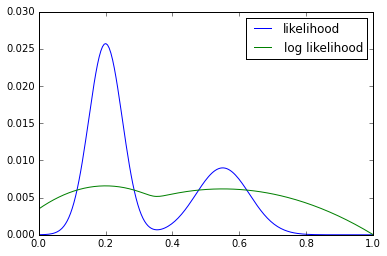

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from numpy.random import randn

def norm(x, x0, sigma):
    return np.exp(-0.5 * (x - x0) ** 2 / sigma ** 2)

# compute some arbitrary multimodal distribution
x = np.linspace(0, 1, 200)
likelihood = norm(x, .2, .05) + .35*norm(x, .55, .08)
likelihood /=  np.sum(likelihood) # normalize it

log_likelihood = np.log(likelihood)
# make it positive and normalized.
log_likelihood += -np.min(log_likelihood)
log_likelihood /= np.sum(log_likelihood)

# plot them
plt.plot(x, likelihood, label='likelihood')
plt.plot(x, log_likelihood, label='log likelihood')
plt.legend();

We can show that the maximum value of each is at the same index with:

In [12]:
print(np.argmax(likelihood))
print(np.argmax(log_likelihood))

40
40


Indeed they are the same. I haven't proven that this relationship is valid, but it is. I don't want to get bogged down in a proof. See any statistics or machine learning textbook if you can't work it out yourself.

If you see log-likelihood being used anywhere just think back to this chart. They have almost certainly introduced the logarithm not for any reason related to the problem, but just to make the computations easier.

## Dealing with Incomplete Data

All of the work above is to prepare us for this, the actual problem. It is easy to compute the bias of 10 coins when we know the flips for each coin. What if we  lost or don't have that association? In other words, we have a sequence of heads and tails recorded, but do not know which coin produced the flips?

This is not a silly question, this is a very common situation in practice. For example **some example here**

Let's look as a plot:

[ 10.   4.   4.  10.  10.   4.  10.  10.]


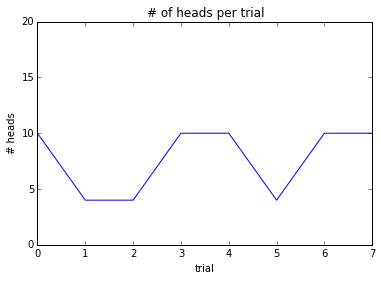

In [30]:
num_trials, num_flips = 8, 20
data = np.zeros(num_trials)
bias1, bias2 = .7, .3
theta = [bias1, bias2]

def run_trials(data, theta):
    num_trials, = data.shape
    flips = random(num_flips)
    for i in range(num_trials):
        if random() < .5:
            data[i] =  np.sum(flips < theta[0])
        else:
            data[i] = np.sum(flips < theta[1])

run_trials(data, theta)
            

plt.plot(data)
plt.title('# of heads per trial')
plt.xlabel('trial')
plt.ylabel('# heads')
plt.ylim(0, 20);
print(data)

By inspection of the code we see that one coin had a bias of $\beta=0.57$ and the second had a bias of $\beta=0.43$. At first glance this problem seems intractable. For example, probability allows for a coin with bias $\beta=.99$ to flip tails 10 times in a row, so we cannot assume that any given trial will have a high number of heads reflects a large bias ($\beta >> 0.5$). If in the code I made the bias for one coin much higher than the other, such as `bias_1 = 0.97`, `bias_2 = 0.007`, we might be able to solve this problem by inspection just by assuming that trials that are all heads are due to coin one and trials with almost all tails are due to coin two. But the differences in data are not generally so stark.

So, in general the problem seems intractable. But, is it? Let's just take a naive approach and see where it gets us.

We need to start somewhere, so lets start by assuming some bias for each coin. We have no reason to assume any value, so I will choose a value at random: 0.75 for the first coin, and 0.3 for the second coin. This is *entirely* arbitrary - I did not inspect the data and somehow infer these numbers. We need to start somewhere.

Let's get this into standard notation. First, we say that

$$\begin{aligned}\beta_1 &= 0.6\\\beta_2 &= 0.3\end{aligned}$$

where $\beta_i$ is the bias for the i$^{th}$ coin. Now we collect them into $\theta$ for notational convenience:

$$\theta = (\beta_1, \beta_2) = (0.6, 0.3)$$

In code we might express this as

In [31]:
theta = np.array((0.6, 0.3))
theta

array([ 0.6,  0.3])

These are very unlikely to be close to accurate, but let's press on. We can now inspect each trial and compute if it is more likely to have been caused by the first coin or second coin based on these biases.

In [32]:
def compute_assignment(biases, theta):
    num_trials = len(biases) 
    assignment = np.zeros(num_trials, dtype=int)
    for i, bias in enumerate(biases):
        assignment[i] = np.abs(theta - bias).argmin()        
    return assignment

bias = data / num_flips
assignment = compute_assignment(bias, theta)

for i in range(len(data)):
    print('coin {} is the closest match for bias {}'
          .format(assignment[i]+1, bias[i]))

coin 1 is the closest match for bias 0.5
coin 2 is the closest match for bias 0.2
coin 2 is the closest match for bias 0.2
coin 1 is the closest match for bias 0.5
coin 1 is the closest match for bias 0.5
coin 2 is the closest match for bias 0.2
coin 1 is the closest match for bias 0.5
coin 1 is the closest match for bias 0.5


Now that we have the assignments, we have an outline for an algorithm. We could start with an initial estimate for $\theta$ and compute which coin is most likely 

If we know there is a probability $p$ for an event, and we observe $d$ occurances of that event over $N$ trials, the probability of that occuring is given by

$$P(\text{data} \, \lvert\, p) = \begin{pmatrix}N\\d\end{pmatrix} p^d (1-p)^{N-d}$$

We will turn that into code with:

In [22]:
from math import log
from scipy.misc import comb

def coin_likelihood(N, d, bias):
    return comb(N, d, exact=True) * bias**d * (1-bias)**(N-d)

def coin_log_likelihood(N, d, bias):
    return np.log(comb(N, d, exact=True) * bias**d * (1-bias)**(N-d))

In [23]:
print(coin_likelihood(N=10, d=5, bias=.7))
print(coin_likelihood(N=10, d=5, bias=.5))
print(coin_log_likelihood(N=10, d=5, bias=.7))
print(coin_log_likelihood(N=10, d=5, bias=.5))

0.10291934520000003
0.24609375
-2.27380965381
-1.40204271809


In [19]:
# style the notebook
from IPython.core.display import HTML
import urllib.request
response = urllib.request.urlopen('http://bit.ly/1LC7EI7')
HTML(response.read().decode("utf-8"))